# Setup

In [378]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:2000px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Prevent long logging lines from wrapping
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
np.set_printoptions(linewidth=np.inf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run experiments

### Boston to Adult

In [1023]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
    'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_33',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 100_000,
    'MIN_FREQ_FILL_PCT': .2,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 2,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
        'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 5
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .01
base_exp_info['IGNORE_RESULTS_EPSILON'] = .025
base_exp_info['MAX_ITER'] = 25
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 25

source_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__WA',
#     'Adult',
#     'COMPAS',
    'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__TX',
    'Adult',
#     'Boston',
#     'COMPAS',
]

### Adult to Boston

In [969]:
# base_exp_info = {
# #     'EXPERIMENT_NAME': 'compas_48_hidden',
# #     'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_44',
# #     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
    
#     'FEAT_EXP_OBJECTIVE_NAMES': [
#         'Acc',
# #         'AccPar',
#         'DemPar',
#         'EqOpp',
# #         'FPRPar',
#         'TNRPar',
# #         'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
# #         'FPR_Z0',
# #         'FPR_Z1',
# #         'FNR_Z0',
# #         'FNR_Z1',
#     ],
#     'PERF_MEAS_OBJECTIVE_NAMES': [
#         'Acc',
#         'DemPar',
#         'EqOpp',
#         'FPRPar',
#         'TNRPar',
#         'FNRPar',
# #         'PR_Z0',
# #         'PR_Z1',
# #         'TPR_Z0',
# #         'TPR_Z1',
# #         'TNR_Z0',
# #         'TNR_Z1',
# #         'FPR_Z0',
# #         'FPR_Z1',
# #         'FNR_Z0',
# #         'FNR_Z1',
#         'PredPar',
#         'NegPredPar',
#     ],
    
#     # Expert demo parameters
# #     'DATASET': 'ACSIncome__CA',
# #     'TARGET_DATASET': 'ACSIncome__IL',
    
#     'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
#     'USE_HIDDEN_FEATURES_SOURCE': True,
#     'USE_HIDDEN_FEATURES_TARGET': False,
    
#     'N_EXPERT_DEMOS': 1,
#     'EXPERT_ALGO': None,
#     'N_DATASET_SAMPLES': 100_000,
#     'MIN_FREQ_FILL_PCT': .2,
#     'RESTRICT_Y_ACTION': True,
#     # IRL Loop parameters
#     'IRL_METHOD': None,
#     'METHOD': 'highs',
#     # Plotting parameters
#     'NOISE_FACTOR': .01,
#     'ANNOTATE': True,
#     'N_INIT_POLICIES': 2,
#     'NON_EXPERT_ALGOS': [
#         'OptAccNoisy',
# #         'HardtDemParNoisy',
#         'HardtEqOppNoisy',
# #         'HardtFPRNoisy',
# #         'HardtTNRNoisy',
# #         'Dummy',
# #         'DummyNoisy',
#     ],
# }

# base_exp_info['N_TRIALS'] = 1
# # base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
# base_exp_info['EPSILON'] = .015
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .03
# base_exp_info['MAX_ITER'] = 25
# base_exp_info['ALLOW_NEG_WEIGHTS'] = True
# base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
# base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 25

# source_states = [
# #     'ACSIncome__AL',
# #     'ACSIncome__CA',
# #     'ACSIncome__FL',
# #     'ACSIncome__IL',
# #     'ACSIncome__ME',
# #     'ACSIncome__NY',
# #     'ACSIncome__TX',
# #     'ACSIncome__WA',
#     'Adult',
# #     'COMPAS',
# #     'Boston',
# ]

# target_states = [
# #     'ACSIncome__AL',
# #     'ACSIncome__CA',
# #     'ACSIncome__FL',
# #     'ACSIncome__IL',
# #     'ACSIncome__ME',
# #     'ACSIncome__NY',
# #     'ACSIncome__TX',
# #     'ACSIncome__TX',
# #     'Adult',
#     'Boston',
# #     'COMPAS',
# ]

### ACSIncome: State to State

In [1061]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
#     'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_33',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
    'EXPERIMENT_NAME': 'ACSIncome_CA_to_WY_jan8_44',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 100_000,
    'MIN_FREQ_FILL_PCT': .3,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 2,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
        'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 1
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .03
base_exp_info['IGNORE_RESULTS_EPSILON'] = .07
base_exp_info['MAX_ITER'] = 25
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 25

source_states = [
#     'ACSIncome__AL',
    'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__WY',
#     'Adult',
#     'COMPAS',
#     'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
    'ACSIncome__WY',
#     'Adult',
#     'Boston',
#     'COMPAS',
]

### Set Experts & Run

In [1062]:
expert_algos = [
#     'OptAcc',
    'HardtDemPar',
    'HardtEqOpp',
#     'HardtTNRPar'
#     'HardtFPRPar',
    'BoundedGroupLoss',
#     'COMPAS',
]
        
experiments = []
for expert_algo in expert_algos:
    for source_dataset in source_states:
        for target_dataset in target_states:
            experiments.append({
                'EXPERT_ALGO': expert_algo,
                'IRL_METHOD': 'FairIRL',
                'DATASET': source_dataset,
                'TARGET_DATASET': target_dataset,
            })

In [1063]:
# experiments = [
#     {
#         'EXPERT_ALGO': 'OptAcc',
#         'IRL_METHOD': 'FairIRL',
#     },
#     {
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#     },
#     {
#         'EXPERT_ALGO': 'HardtEqOpp',
#         'IRL_METHOD': 'FairIRL',
#     },
# #     {
# #         'EXPERT_ALGO': 'COMPAS',
# #         'IRL_METHOD': 'FairIRL',
# #         'USE_HIDDEN_FEATURES_SOURCE': True,
# #         'USE_HIDDEN_FEATURES_TARGET': False,
# #         'EXPERT_CANNOT_PREDICT_IN_TARGET': True,
# #     },
    
    
# #     {
# #         'EXPERT_ALGO': 'OptAcc',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# #     {
# #         'EXPERT_ALGO': 'HardtDemPar',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# #     {
# #         'EXPERT_ALGO': 'HardtEqOpp',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# ]

In [1064]:
# for exp_i, experiment in enumerate(experiments):
#     logging.info('\n\n')
#     logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
#     exp_info = dict(base_exp_info)
    
#     for k in experiment:
#         exp_info[k] = experiment[k]
        
#     run_experiment(exp_info)

In [1065]:
exp_info = dict(base_exp_info)

In [ ]:
for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    source_X, source_y, source_feature_types = generate_dataset(
        experiment['DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    target_X, target_y, target_feature_types = generate_dataset(
        experiment['TARGET_DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    for f in source_feature_types['categoric']:
        source_X[f] = source_X[f].astype(str)

    for f in target_feature_types['categoric']:
        target_X[f] = target_X[f].astype(str)
                   
    source_X_cols = (
        source_feature_types['boolean']
        + source_feature_types['categoric']
        + source_feature_types['continuous']
    )
    
    if exp_info['USE_HIDDEN_FEATURES_SOURCE']:
        source_X_cols += source_feature_types['hidden']
    _source_X = source_X[source_X_cols]
    
    
    target_X_cols = (
        target_feature_types['boolean']
        + target_feature_types['categoric']
        + target_feature_types['continuous']
    )
    if exp_info['USE_HIDDEN_FEATURES_TARGET']:
        target_X_cols += target_feature_types['hidden']
    _target_X = target_X[target_X_cols]
    
    source_beh_clone_clf = run_behavior_clone_experiment(
        exp_info,
        source_X=_source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=_target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

    source_clf_pol, target_clf_pol = run_experiment(
        exp_info,
        source_X=_source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=_target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

INFO:root:


INFO:root:EXPERIMENT 1/3


# Compare results with source domain only

In [1029]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [1030]:
# min_exp_timestamp = '2023-08-12 20:22:00'  # Cutoff for results of main text in AAAI submission
min_exp_timestamp = '2024-01-10 09:50:00'  # Cutoff for results on Appendix D.4 (progressively increasing expert)

def skip_by_name(info):
    return 'EXPERIMENT_NAME' not in info or info['EXPERIMENT_NAME'] != base_exp_info['EXPERIMENT_NAME']

### Compare each expert's demonstrations vs learned

Experiment ID: boston_to_adult_jan8_44
DATASET: None


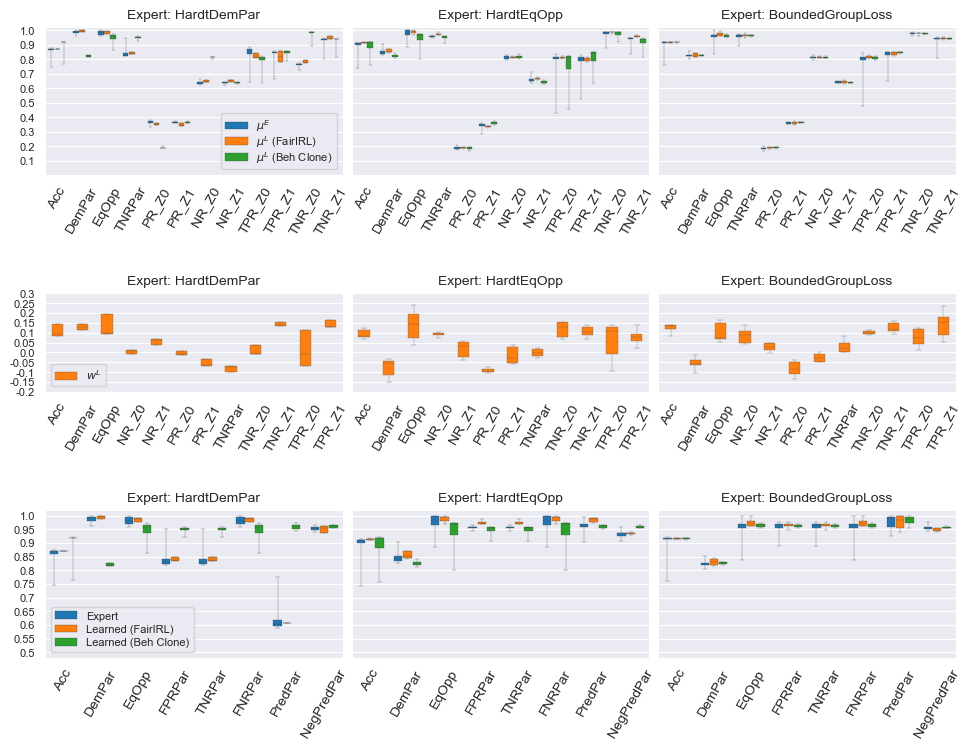

In [1037]:
size_mult = 1.0
plt.rc('axes', titlesize=10*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=10*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=8*size_mult)    # legend fontsize
plt.rc('figure', titlesize=10*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_source_domain_only(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
        'PredPar',
        'NegPredPar',
    ],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=[
#         'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtFPRPar',
#         'HardtEqOdds',
        'BoundedGroupLoss',
#         'COMPAS',
    ],
#     dataset=exp_info['DATASET'],
    dataset=None,
    mu_noise_factor=0,
    perf_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=[
        'Expert',
        'Learned (FairIRL)',
        'Learned (Beh Clone)',
#         None,
#         None,
    ],
    w_hue_order=[
#         None,
        'wL (FairIRL)',
#         None,
#         'wL (FairIRLFO)',
    ],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
#     max_mu_value=1,
#     min_w_value=-.05,
    mu_yticks=np.linspace(.1, 1, 10).round(1),
    mu_ylim=(0, 1.02),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 41).round(2),
    w_ylim=(-.2, .3),
    w_whis=[1, 99],
    w_palette=[cp[1]],
    perf_ylim=(.48, 1.02),
    perf_yticks=np.linspace(0, 1, 21).round(2),
    perf_whis=[1, 99],
#     min_perf_value=.6,
    size_mult=size_mult,
    figsize=(10, 7),
    palette=cp,
    perf_leg_ax=0,
)

rotation = 60
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
        axes[2][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)
    axes[2].tick_params(axis='x', rotation=rotation)
    
    
# axes[1][0].legend(labels=['$w^L$'])
axes[1][0].get_legend().get_texts()[0].set_text('$w^L$')

### Compare just IRL learned policies

Experiment ID: boston_to_compas_jan8_16


DATASET: Boston


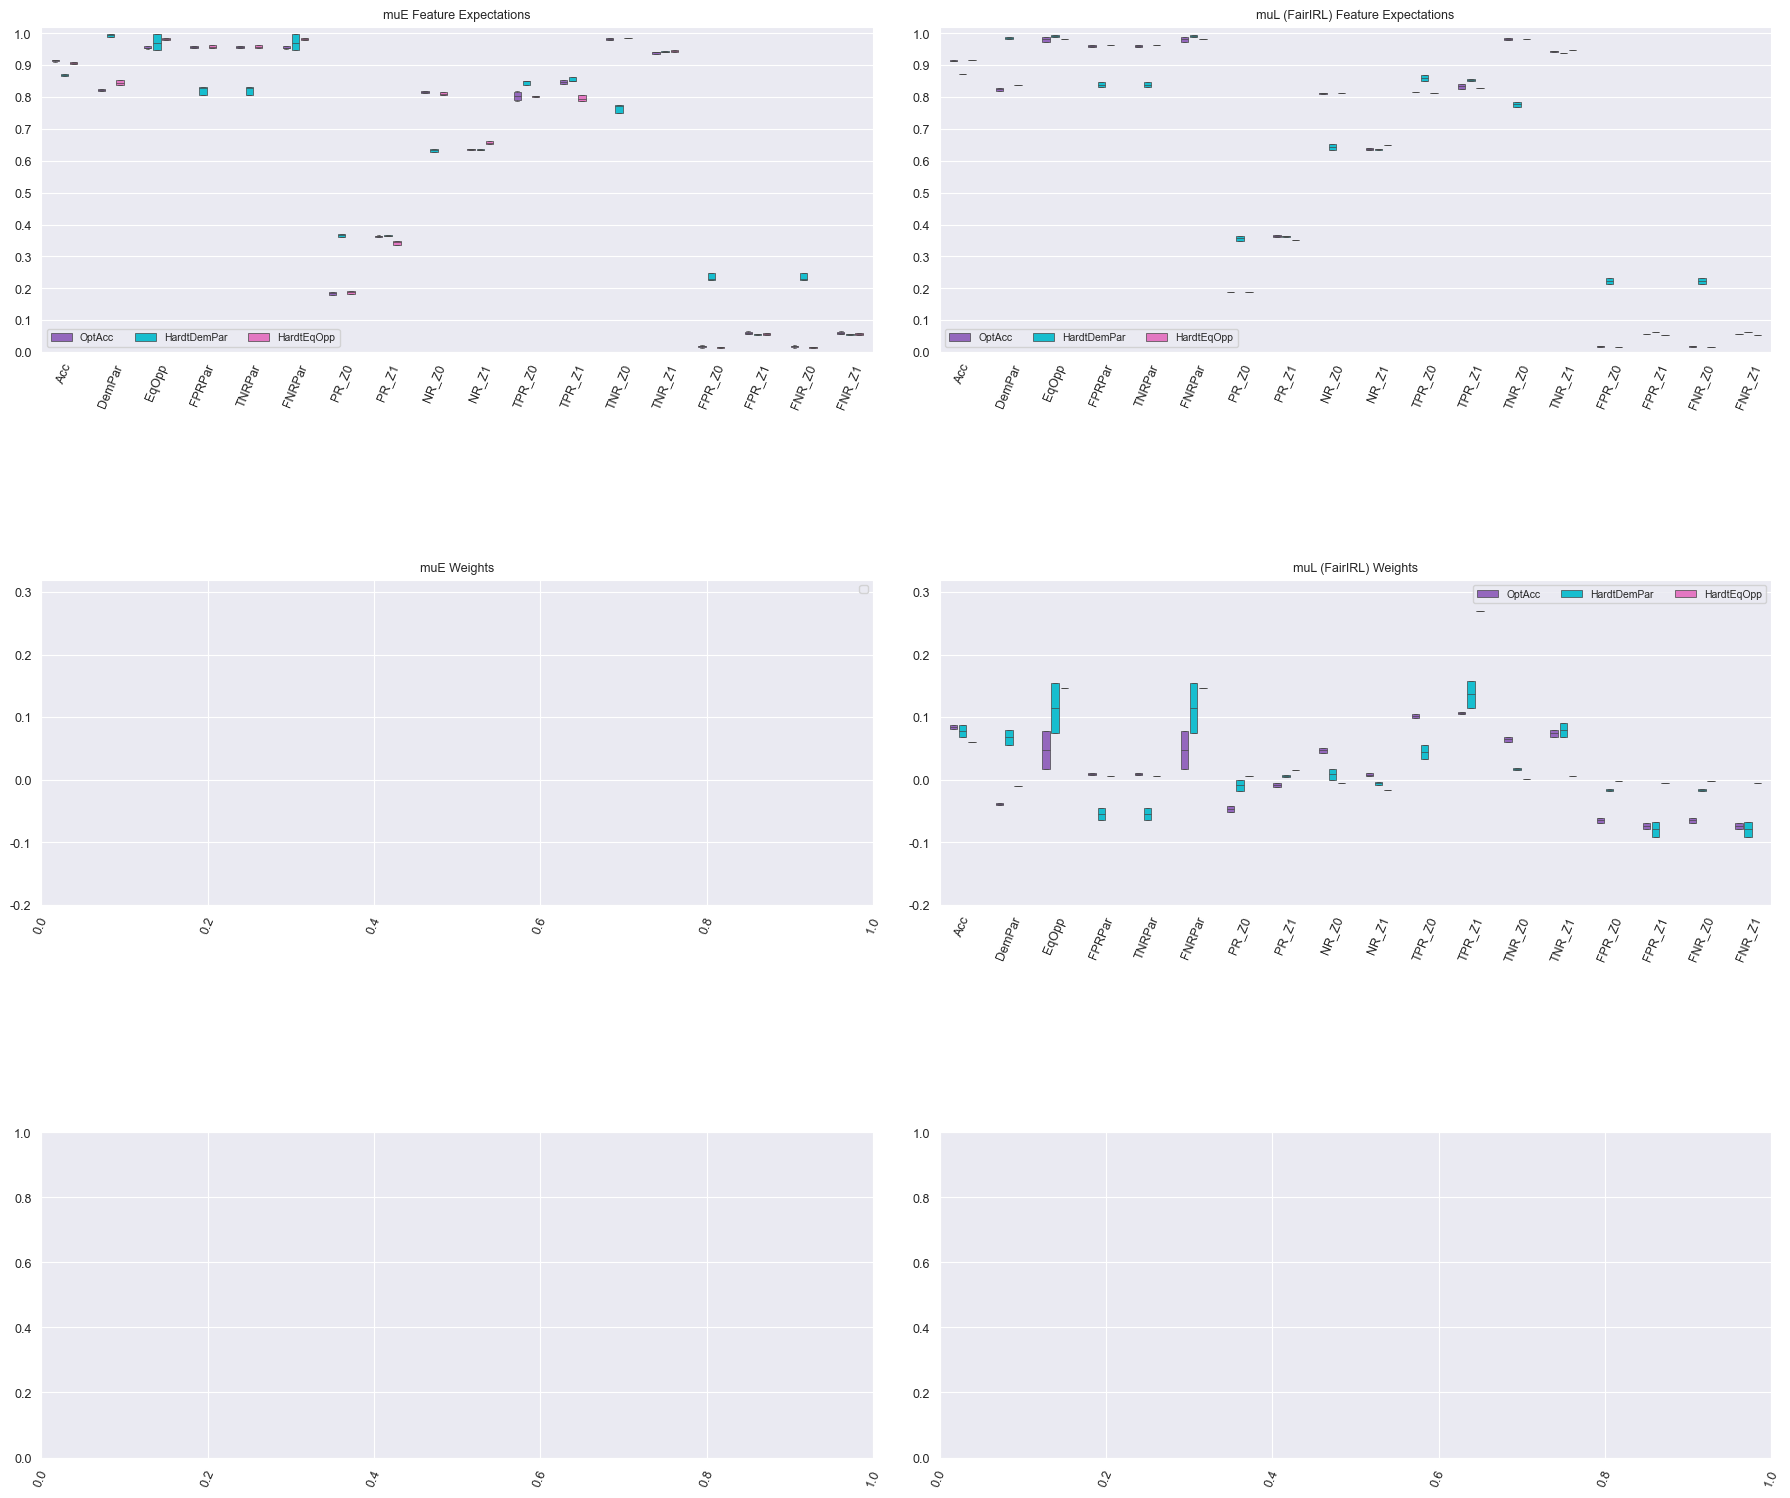

In [391]:
size_mult = 1.5
plt.rc('axes', titlesize=6*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=6*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=6*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=5*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_source_fair_irl_comparisons(
    feat_objective_set_names=base_exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
#         'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
#         'OppPredPar',
    ],
    expert_algos=[
        'OptAcc',
#         'COMPAS',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtTNRPar',
#         'RedBoundedGroupLoss',
    ],
    dataset=exp_info['DATASET'],
    demo_producers=[
        'muE',  # source
        'muL (FairIRL)',  # source
    ],
    mu_noise_factor=0,
    perf_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=[
        'Expert',
        'Learned (FairIRL)',
        'Learned (Beh Clone)',
#         None,
#         None,
    ],
    w_hue_order=[
        None,
        'wL (FairIRL)',
#         None,
#         'wL (FairIRLFO)',
    ],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(0, 1.02),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 21).round(1),
    w_ylim=(-.2, .32),
    perf_ylim=(.45, 1.05),
    perf_yticks=np.linspace(.5, 1, 6).round(1),
    size_mult=size_mult,
    palette=[cp[4], cp[9], cp[6], cp[8]],
    figsize=(18, 15),
)

rotation = 67.5
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
        axes[2][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)
    axes[2].tick_params(axis='x', rotation=rotation)


# Compare results with target domain

### Compare each expert's demo vs learned

Experiment ID: boston_to_adult_jan8_44
SOURCE DATASET: Boston
TARGET DATASET: Adult


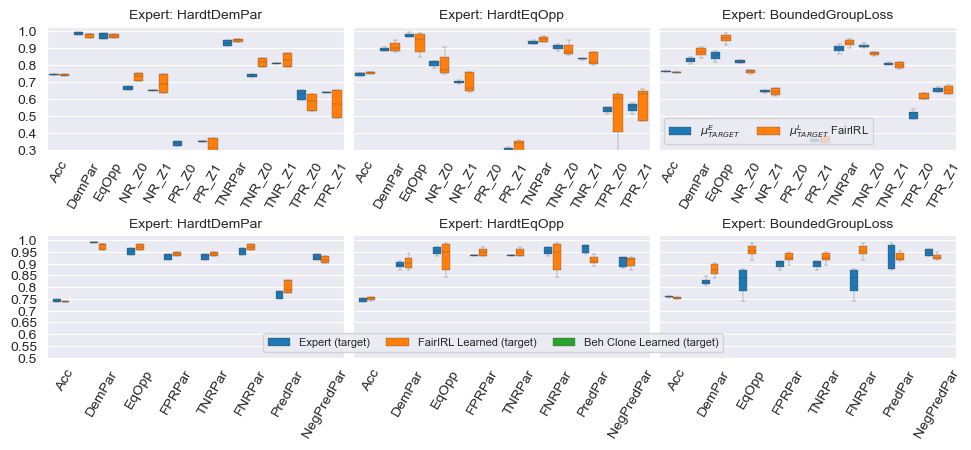

In [1038]:
## plt.rc('axes', titlesize=11)     # fontsize of the axes title
size_mult = 1.
plt.rc('axes', titlesize=10*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=10*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=8*size_mult)    # legend fontsize
plt.rc('figure', titlesize=10*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])

fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_target_domain(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=[
#         'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
        'BoundedGroupLoss',
#         'HardtFPRPar'
#         'COMPAS',
    ],
    source_dataset=exp_info['DATASET'],
    target_dataset=exp_info['TARGET_DATASET'],
#     source_dataset=None,
#     target_dataset=None,
    mu_noise_factor=0,
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(.3, 1.02),
    mu_whis=[1, 99],
    perf_noise_factor=0,
    perf_ylim=(.5, 1.02),
    perf_yticks=np.linspace(0, 1, 21).round(2),
    size_mult=size_mult,
    mu_hue_order=[  
#         'muE',
        'muE_target',
#         'muL (FairIRL)',
#         'muL (FairIRLFO)',
        'muL_target FairIRL',

    ],
    perf_hue_order=[
#         'Expert (source)',
        'Expert (target)',
        'FairIRL Learned (target)',
        'Beh Clone Learned (target)',
    ],
    figsize=(10, 4),
    perf_leg_ax=2,
)

rotation = 60
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)

### Compare just IRL learned policies

Experiment ID: boston_to_adult_jan8_32
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jackblandin/miniconda3/envs/research/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_94545/75908256.py", line 11, in <module>
    fig, axes, mu_dfs, w_dfs, perf_dfs = plot_target_fair_irl_comparisons(
  File "/Users/jackblandin/my/research/experiments/irl/experiment_utils.py", line 3150, in plot_target_fair_irl_comparisons
    raise ValueError(f"No results for provided config.")
ValueError: No results for provided config.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jackblandin/miniconda3/envs/research/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/jackblandin/miniconda3/envs/research/lib/python3.

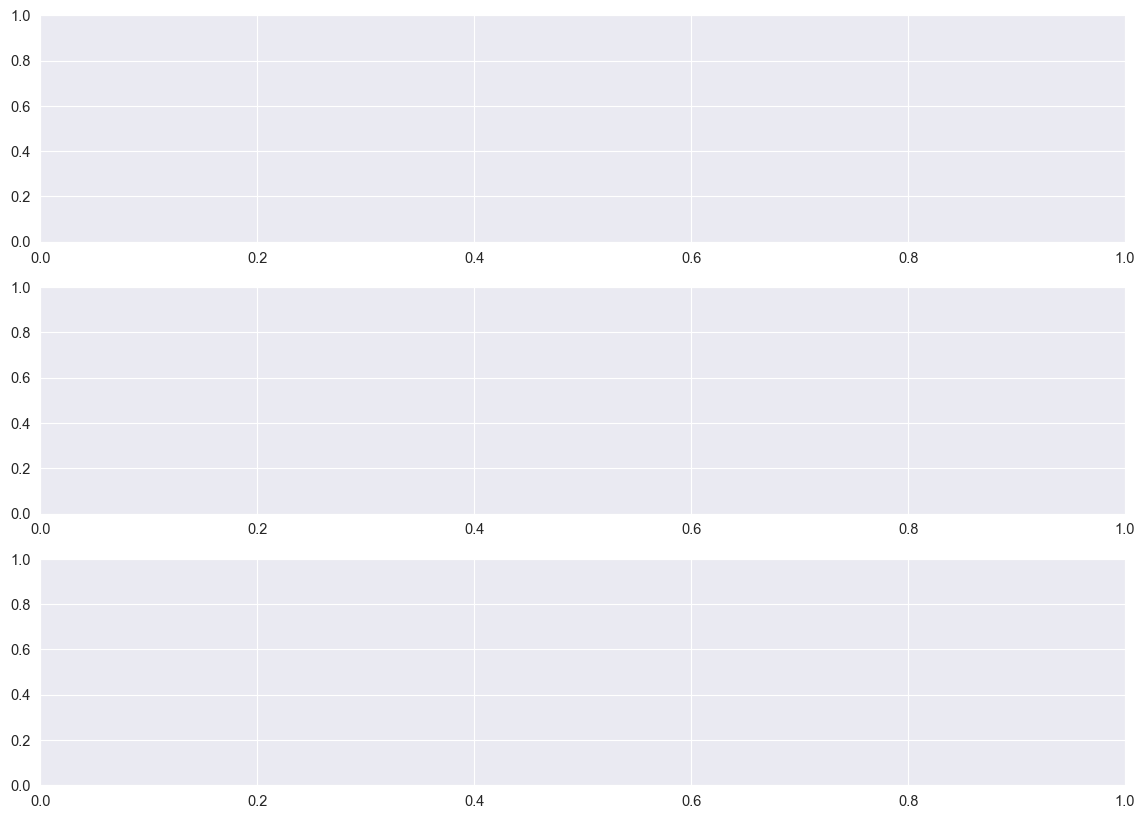

In [342]:
size_mult = 1.5
plt.rc('axes', titlesize=9*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=9*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=7*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=6*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_target_fair_irl_comparisons(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
    perf_objective_set_names=exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    expert_algos=[
        'OptAcc',
        'COMPAS',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtTNRPar',
#         'RedBoundedGroupLoss',
    ],
    dataset=exp_info['DATASET'],
    feat_demo_producers=[
#         'muE',
#         'muE_target',
#         'muL_source FairIRL',
        'muL_target FairIRL',
    ],
    perf_demo_producers=[
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
#         'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
#         'OppPredPar',
    ],
    w_demo_producers=[
      'wL (FairIRL)',
    ],
    mu_noise_factor=.001,
    perf_noise_factor=.001,
    w_noise_factor=.001,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    max_mu_value=1,
    min_w_value=-.05,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(0, 1.05),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 101).round(1),
    w_ylim=(-.05, .35),
    perf_ylim=(.45, 1.05),
    perf_yticks=np.linspace(0, 1, 11).round(1),
    size_mult=size_mult,
    figsize=(14, 10)
)
print(f"Source Dataset: {exp_info['DATASET']}")
print(f"Target Dataset: {exp_info['TARGET_DATASET']}")

# Scratch

In [170]:
exp_info = dict(base_exp_info)
exp_info['FEAT_EXP_OBJECTIVE_NAMES'] = [
    'TPR_Z0', 'TPR_Z1',
#     'TNR_Z0', 'TNR_Z1',
    'FPR_Z0', 'FPR_Z1',
#     'FNR_Z0', 'FNR_Z1',
#     'Acc',
#     'DemPar',
#     'EqOpp',
#     'PredPar',
]
exp_info['RESTRICT_Y_ACTION'] = True

X, y, ft = generate_compas_dataset(20_000)
# X, y, ft = generate_adult_dataset(20_000)

# Initiate objectives
objectives = []
for obj_name in exp_info['FEAT_EXP_OBJECTIVE_NAMES']:
    objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
feat_obj_set = ObjectiveSet(objectives)
del objectives
# Reset the objective set since they get fitted in each trial run
feat_obj_set.reset()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
)
del X, y


# Fit a classifier that predicts `y` from `X`.
clf = sklearn_clf_pipeline(
    feature_types=ft,
    clf_inst=RandomForestClassifier(),
)
clf.fit(X_train, y_train)

# Initiate variables needed to run IRL Loop
x_cols = (
    ft['boolean']
    + ft['categoric']
    + ft['continuous']
)
x_cols.remove('z')

# wi = [.2, .3, -.15, -.2]  # .598, .881, .906
# wi = [.195, .22, -.205, -.17]  # .608, .984, .994
wi = [.2, .3, .15, .2]  # .598, .881, .906
# wi = [.9, .02, .02]


reward_weights = { obj.name: wi[j] for j, obj in enumerate(feat_obj_set.objectives) }

test_df = X_test.copy()
test_df['y'] = y_test
# test_df = X_train.copy()
# test_df['y'] = y_train
# test_df['y'] = clf.predict(X_test)

clf_pol = compute_optimal_policy(
    clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
    clf=clf,
    x_cols=x_cols,
    obj_set=feat_obj_set,
    reward_weights=reward_weights,
    skip_error_terms=True,
    method=exp_info['METHOD'],
    min_freq_fill_pct=exp_info['MIN_FREQ_FILL_PCT'],
)

demo = generate_demo(clf_pol, X_train, y_train, can_observe_y=False)
muj = feat_obj_set.compute_demo_feature_exp(demo)
print(f"\t\t muL = {np.round(muj, 3)}")


print('Acc', AccuracyObjective().compute_feat_exp(demo).round(3))
print('DemPar', DemographicParityObjective().compute_feat_exp(demo).round(3))
print('EqOpp', EqualOpportunityObjective().compute_feat_exp(demo).round(3))

display(demo.groupby(['z', 'y'])[['yhat']].agg(['count', 'mean', 'sum']))
display(demo.groupby(['z'])[['yhat']].agg(['count', 'mean', 'sum']))

		 muL = [0.748 0.776 0.503 0.396]
Acc 0.605
DemPar 0.947
EqOpp 0.972


yhat                  
    count      mean     sum
z y                        
0 0  4608  0.496745  2289.0
  1  4768  0.748112  3567.0
1 0  2650  0.604151  1601.0
  1  1970  0.776142  1529.0

yhat                  
  count      mean     sum
z                        
0  9376  0.624573  5856.0
1  4620  0.677489  3130.0

# HW Scratch

In [11]:
from math import comb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Problem 1

In [28]:
def expected_4_cliques(n, p):
    return comb(n, 4) * p**6

In [45]:
def thresh_4_clique(n):
    return comb(n, 4)**(-(1/6))

In [120]:
expected_4_cliques(int(1e15), p=1e-9)

41666.66666666643

100000 0.0007883266647717149
1000000 0.0001698383027949114
10000000 3.659052019222436e-05


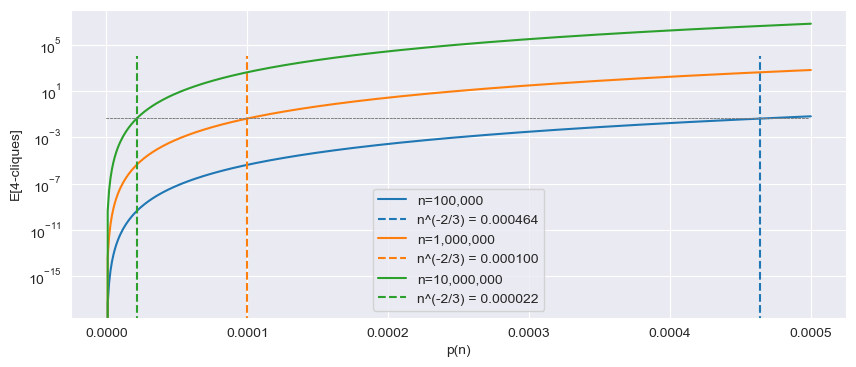

In [237]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cp = sns.color_palette()

for i, n in enumerate([100_000, 1_000_000, 10_000_000]):
    x = np.linspace(0, .0005, 501)
    y = [expected_4_cliques(n, p) for p in x]
    ax.plot(x, y, label=f"n={n:,}", c=cp[i])
    ax.set_xlabel('p(n)')
    ax.set_ylabel('E[4-cliques]')
    print(n, thresh_4_clique(n))
    
    thresh = n**(-2/3)
    threshx = [thresh for _ in range(10)]
    threshy = np.linspace(0, 1e4, 10)
    ax.plot(threshx, threshy, ls='--', label=f"n^(-2/3) = {thresh:.6f}", c=cp[i])
    
    x2 = np.linspace(0, .95*ax.get_xlim()[1], 2)
    y2 = .05*np.ones(2)
    ax.plot(x2, y2, ls='--', lw=.5, c='gray')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
pass

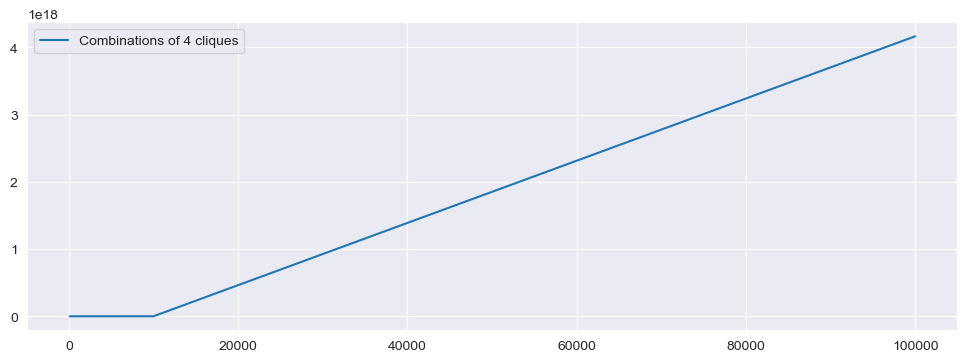

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x1 = [100, 1_000, 10_000, 100_000]
y1 = [comb(n, 4) for n in x1]
x2 = np.linspace(0, 1, 101)
y2 = [p**6 for p in x2]
ax.plot(x1, y1, label='Combinations of 4 cliques')
# ax.plot(x2, y2, label='p^6(n)')
ax.legend()

In [42]:
comb(1000, 4) * 2**(-(comb(4, 2)))

647142574.21875

In [43]:
2**(-(comb(4, 2)))

0.015625

### Problem 4

In [157]:
def prob_vertex_has_deg_k(n, k, p):
    return comb(n, k) * (p**k) * (1-p)**(n-k)

In [197]:
k_range = [
    3,
    int(np.log(n)),
    int(np.sqrt(n)),
    int(n-1),
]
n = 1_000
d = 100
p = d / n

for k in k_range:
    output = n * comb(n, k) * (p**k)
    print(k, ':', output)

3 : 166167000.00000003
6 : 1368173298991.5005
31 : 7.602322407769473e+30
999 : 0.0
